In [1]:
import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
import pandas as pd
import numpy as np
import glob, os

import itertools

from backtester.exoinfo import EXOInfo
from exobuilder.data.exostorage import EXOStorage
from IPython.core.display import display, HTML

import pandas as pd
import numpy as np
import scipy
import pprint

%pylab inline
figsize(20,10)

Populating the interactive namespace from numpy and matplotlib


In [49]:
#
# random time series
#
df = pd.DataFrame()
for i in range(100):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

In [2]:
# Only Cont Fut Flag
only_cont_fut = True

In [3]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)
pp = pprint.PrettyPrinter(indent=4)

exo_list = storage.exo_list()
pp.pprint(exo_list)


df = pd.DataFrame()

for e in exo_list:
    exo_series, exo_dict = storage.load_series(e)
    if only_cont_fut == True:   
        if 'Fut' in exo_dict['name']:   
            exo_series = exo_series[exo_series.columns[0]]
            df[exo_dict['name']] = exo_series
            
    if only_cont_fut == False:
        exo_series = exo_series[exo_series.columns[0]]
        df[exo_dict['name']] = exo_series
#exo_series.plot()

[   'ES_BullishCollarBW',
    'ES_BearishCollarBW',
    'ES_CallSpread',
    'ES_PutSpread',
    'ES_ContFut',
    'ZS_BullishCollarBW',
    'ZS_BearishCollarBW',
    'ZS_CallSpread',
    'ZS_PutSpread',
    'ZS_ContFut',
    'CL_BullishCollarBW',
    'CL_BearishCollarBW',
    'CL_CallSpread',
    'CL_PutSpread',
    'CL_ContFut',
    'ZW_BullishCollarBW',
    'ZW_BearishCollarBW',
    'ZW_CallSpread',
    'ZW_PutSpread',
    'ZW_ContFut',
    'ZN_BullishCollarBW',
    'ZN_BearishCollarBW',
    'ZN_CallSpread',
    'ZN_PutSpread',
    'ZN_ContFut',
    'NG_BullishCollarBW',
    'NG_BearishCollarBW',
    'NG_CallSpread',
    'NG_PutSpread',
    'NG_ContFut',
    'ZC_BullishCollarBW',
    'ZC_BearishCollarBW',
    'ZC_CallSpread',
    'ZC_PutSpread',
    'ZC_ContFut']


In [4]:
df.head()

,ES_ContFut,ZS_ContFut,CL_ContFut,ZW_ContFut,ZN_ContFut,NG_ContFut,ZC_ContFut
2011-03-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-02,62.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-03,1187.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-04,462.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-05,650.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
px_ser = df.CL_ContFut

In [54]:
'''
Tenkan-sen (Conversion Line): (9-period high + 9-period low)/2)) 

The default setting is 9 periods and can be adjusted. On a daily 
chart, this line is the mid point of the 9 day high-low range, 
which is almost two weeks. 
'''
conversion_line_period = 9 # subject of optimization

conversion_line_high = px_ser.rolling(window=conversion_line_period).max()
conversion_line_low = px_ser.rolling(window=conversion_line_period).min()

conversion_line = (conversion_line_high + conversion_line_low) / 2

'''
Kijun-sen (Base Line): (26-period high + 26-period low)/2)) 

The default setting is 26 periods and can be adjusted. On a daily 
chart, this line is the mid point of the 26 day high-low range, 
which is almost one month).
'''
base_line_period = 26 # subject of optimization

base_line_high = px_ser.rolling(window=base_line_period).max()
base_line_low = px_ser.rolling(window=base_line_period).min()

base_line = (base_line_high + base_line_low) / 2

'''
Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2)) 

This is the midpoint between the Conversion Line and the Base Line. 
The Leading Span A forms one of the two Cloud boundaries. It is 
referred to as "Leading" because it is plotted 26 periods in the future
and forms the faster Cloud boundary. 
'''
leading_span_lookahead_period = 26 # subject of optimization
leading_span_a = ((conversion_line + base_line) / 2).shift(leading_span_lookahead_period)

# straightforward time shifting to 'leading_span_lookahead_period' number of days
#leading_span_a.index = leading_span_a.index + pd.DateOffset(days=leading_span_lookahead_period)

'''
Senkou Span B (Leading Span B): (52-period high + 52-period low)/2)) 

On the daily chart, this line is the mid point of the 52 day high-low range, 
which is a little less than 3 months. The default calculation setting is 
52 periods, but can be adjusted. This value is plotted 26 periods in the future 
and forms the slower Cloud boundary.
'''
leading_span_b_period = 52 # subject of optimization
leading_span_b = ((px_ser.rolling(window=leading_span_b_period).max() + 
                   px_ser.rolling(window=leading_span_b_period).min()) / 2).shift(leading_span_lookahead_period)

# straightforward time shifting to 'leading_span_lookahead_period' number of days
#leading_span_b.index = leading_span_b.index + pd.DateOffset(days=leading_span_lookahead_period)

'''
Chikou Span (Lagging Span): Close plotted 26 days in the past
The default setting is 26 periods, but can be adjusted.
'''
lagging_span_periods = 26 # subject of optimization
lagging_span = px_ser.shift(-lagging_span_periods)

In [55]:
cloud_top = leading_span_b.rolling(1).min()
cloud_bottom = leading_span_a.rolling(1).max()

# Trend Down condition

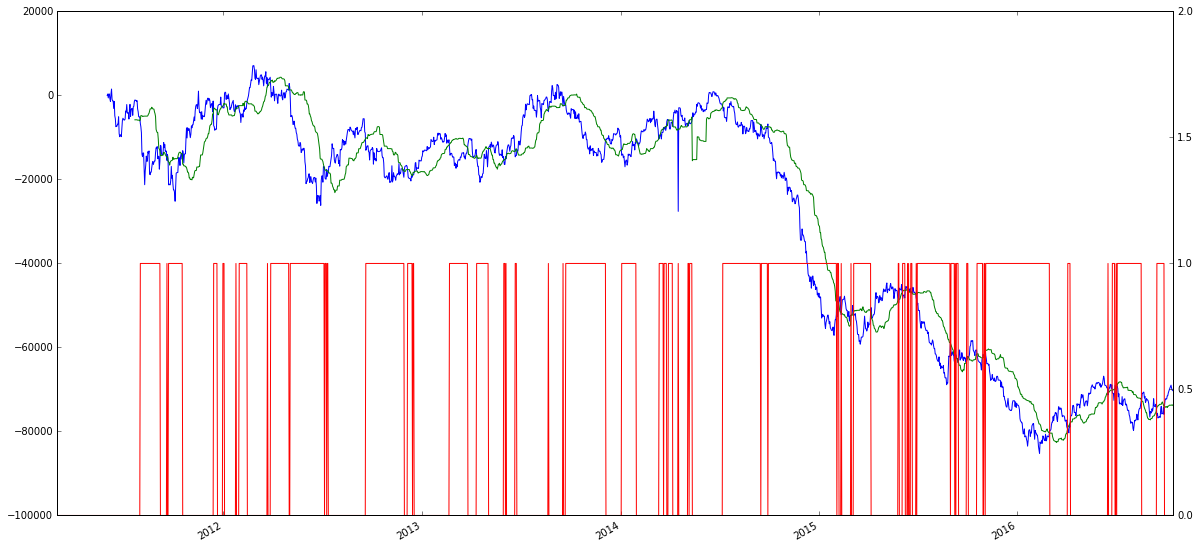

In [56]:
px_ser.plot()
cloud_bottom.plot()

down_trend_cond = px_ser < cloud_bottom

down_trend_cond.plot(secondary_y=True)
axhline(2)

# Trend Up condition

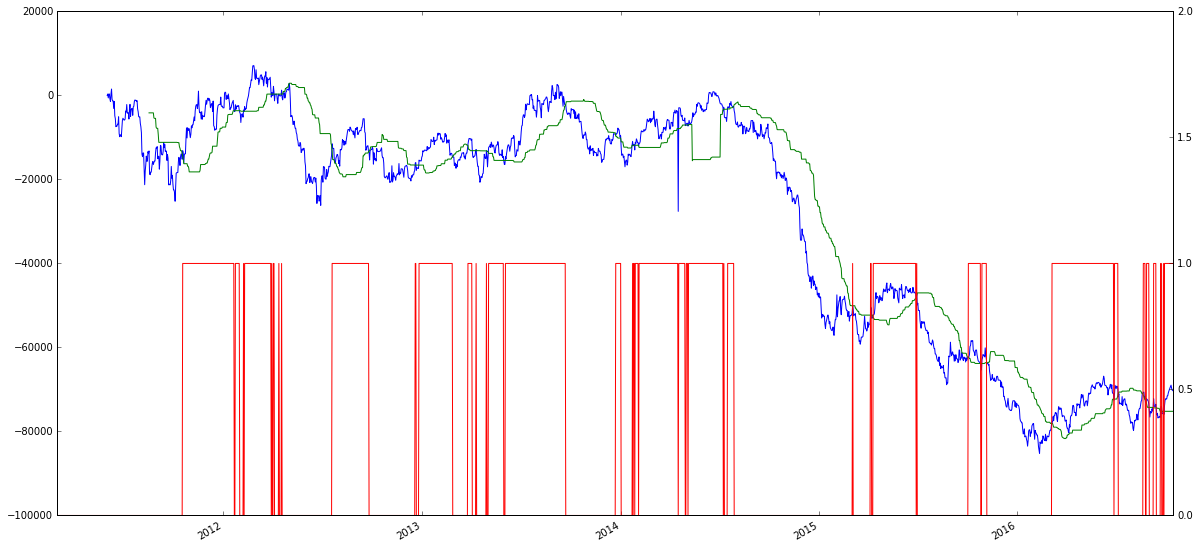

In [57]:
px_ser.plot()
cloud_top.plot()

up_trend_cond = px_ser > cloud_top

up_trend_cond.plot(secondary_y=True)
axhline(2)

# Neutral condition

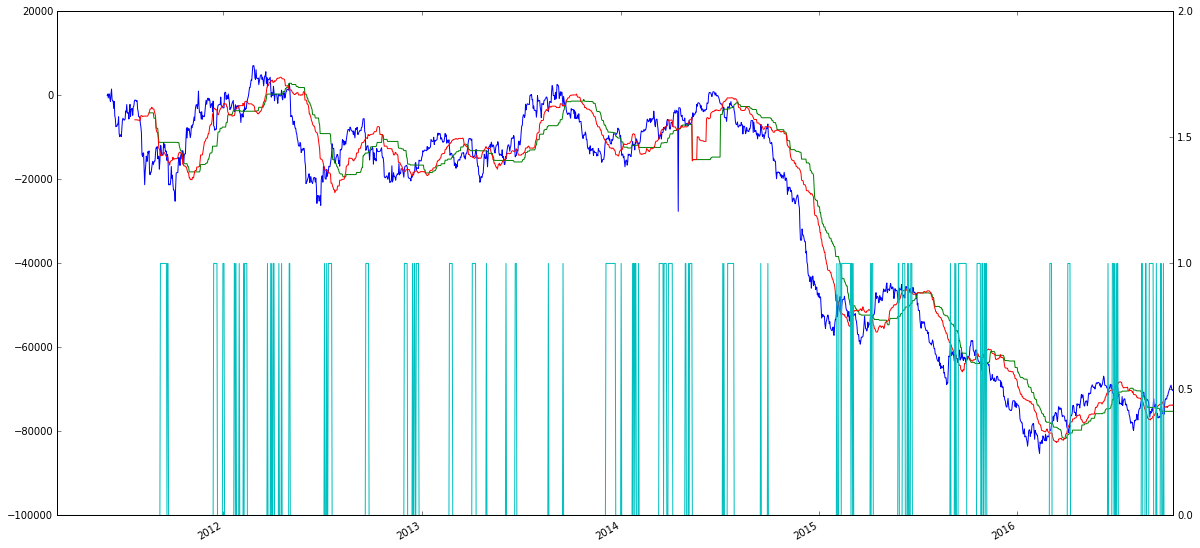

In [58]:
px_ser.plot()
cloud_top.plot()
cloud_bottom.plot()

neutral_cond = ( (px_ser < cloud_top) & (px_ser > cloud_bottom) ) | ((px_ser > cloud_top) & (px_ser < cloud_bottom))

neutral_cond.plot(secondary_y=True)
axhline(2)

# Long SmartEXO

In [73]:
smartexo_ser = pd.Series(index=px_ser.index)

px_1d_diff = px_ser.diff()

for i in range(len(px_1d_diff)):
    if up_trend_cond[i] == True:
        smartexo_ser[i] = px_1d_diff[i] * 1.5
    
    elif down_trend_cond[i] == True:
        smartexo_ser[i] = px_1d_diff[i] * 0.2
        
    elif neutral_cond[i] == True:
        smartexo_ser[i] = px_1d_diff[i] * 0.5
        
    else:
        smartexo_ser[i] = px_1d_diff[i]

smartexo_ser = smartexo_ser.cumsum()

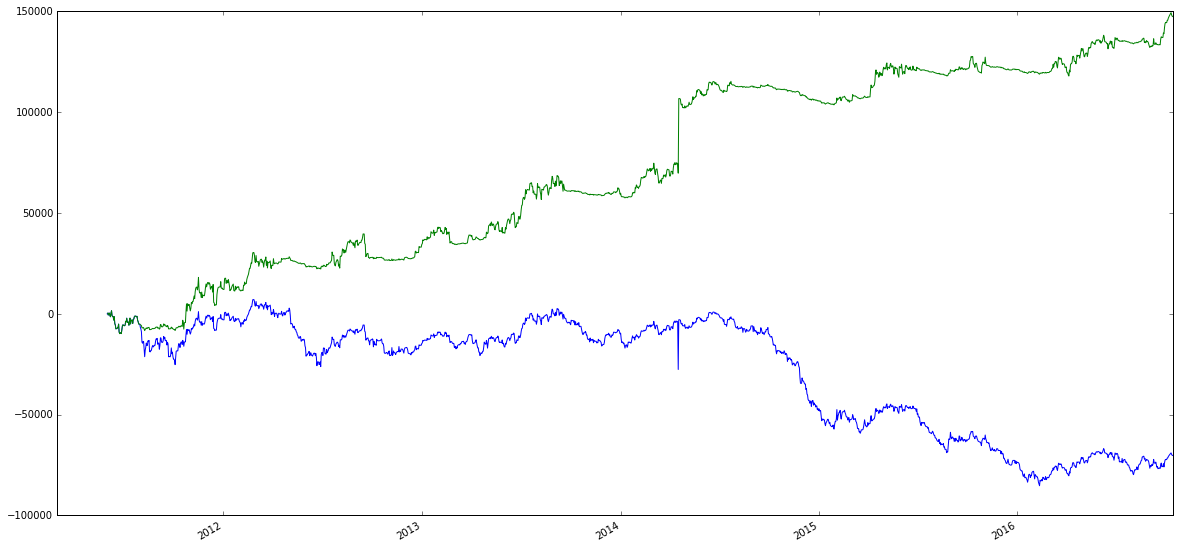

In [74]:
#px_ser.diff().cumsum().plot()
px_ser.plot()
smartexo_ser.plot(label='SmartEXO')

# Short SmartEXO

In [61]:
smartexo_ser = pd.Series(index=px_ser.index)

px_1d_diff = px_ser.diff()

for i in range(len(px_1d_diff)):
    if up_trend_cond[i] == True:
        smartexo_ser[i] = px_1d_diff[i] * -0.2
    
    elif down_trend_cond[i] == True:
        smartexo_ser[i] = px_1d_diff[i] * -1.5
        
    elif neutral_cond[i] == True:
        smartexo_ser[i] = px_1d_diff[i] * 0.5
        
    else:
        smartexo_ser[i] = px_1d_diff[i]

smartexo_ser = smartexo_ser.cumsum()

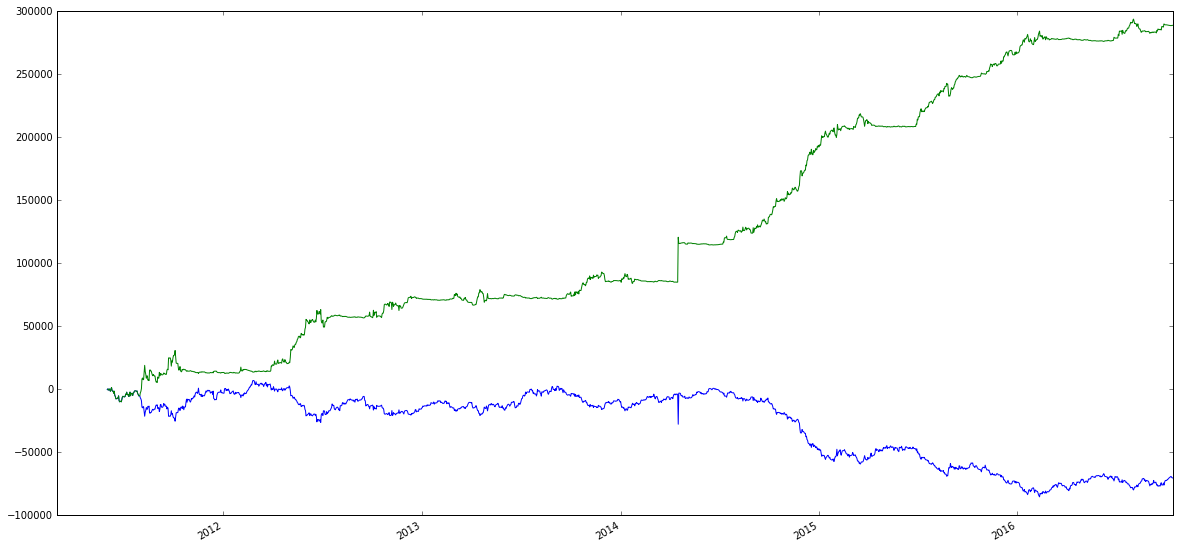

In [62]:
#px_ser.diff().cumsum().plot()
px_ser.plot()
smartexo_ser.plot(label='SmartEXO')